In [1]:
# reload imports so if you change stuff in models/cppn.py it'll update the notebook periodically to see it.
%load_ext autoreload
%autoreload 2


import sys
sys.path.append('/Users/Heysoos/Documents/Pycharm Projects/Dissertation/01_CPPN')
from models.cppn import CPPN, Sampler, multiscale_targets_apply

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from copy import deepcopy

import matplotlib.pyplot as plt
import imageio
from PIL import Image, ImageDraw
from scipy.ndimage import gaussian_filter
from datetime import datetime
from tqdm.auto import tqdm

# from perlin_numpy import (
#     generate_perlin_noise_2d, generate_fractal_noise_2d
# )

from perlin_cupy import (
    generate_fractal_noise_2d, generate_fractal_noise_3d,
    generate_perlin_noise_2d, generate_perlin_noise_3d
)

from IPython.display import display, clear_output
import time

def resize_and_crop(img_path, output_size=(256, 256)):
    img = Image.open(img_path)

    # Calculate scaling factor to resize the image
    scaling_factor = max(output_size[0] / img.width, output_size[1] / img.height)

    # New size maintaining the aspect ratio
    new_size = (int(img.width * scaling_factor), int(img.height * scaling_factor))

    # Resize the image
    img = img.resize(new_size, Image.ANTIALIAS)

    # Calculate coordinates to crop the image to the target size
    left = (img.width - output_size[0]) / 2
    top = (img.height - output_size[1]) / 2
    right = (img.width + output_size[0]) / 2
    bottom = (img.height + output_size[1]) / 2

    # Crop the image
    img = img.crop((left, top, right, bottom))

    return img

def load_image_to_coords(target_file, crop_size, coords):
    coords_shape = coords[0].shape
    img = resize_and_crop(target_file, crop_size)
    img = torch.cuda.FloatTensor(np.array(img).mean(axis=-1)).reshape(*coords_shape) / 255.
    img = img - img.mean()

    return img

def min_max(mat):
    return (mat - mat.min()) / (mat.max() - mat.min())

def inject_perlin_noise(out_shape, seed=0):
    lacunarity = 2
    octaves = 5
    res_n = (8, 8)
    mul = res_n[0]
    max_dim = int(np.ceil(np.max(out_shape) / mul) * mul)
    np.random.seed(seed)
    noise = generate_fractal_noise_2d(shape=(max_dim, max_dim), res=res_n, octaves=octaves, lacunarity=lacunarity)
    noise = noise[0:out_shape[0],0:out_shape[1]]
    return torch.cuda.FloatTensor(noise)

def make_circle(shape, radius):
    image = Image.new('1', shape)  # create new image, 1 bit per pixel
    draw = ImageDraw.Draw(image)
    r = int(np.min(shape) / 2 * radius)
    mid_x = int(shape[0] / 2)
    mid_y = int(shape[1] / 2)

    draw.ellipse((mid_x-r, mid_y-r, mid_x+r, mid_y+r), fill ='white')
    image = 1. * np.array(image)


    return torch.cuda.FloatTensor(image)

C:\Users\Heysoos\anaconda3\envs\torchstuff\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some model configurations I've experimented with.

In [16]:
# net_size = [1024, 32, 256, 16, 128, 6]
# net_size = [512, 32, 256, 16, 128, 6, 6, 6, 6, 6, 6]
# net_size = [128, 128, 64, 64, 32, 32, 16, 8]
# net_size = np.tile([256, 16, 8], 2)
# net_size = [32, 64, 128, 512, 256, 128, 64, 32]
# net_size = [512, 64, 32, 16, 8]
# net_size = [512, 32, 32, 16] ## pretty
# net_size = [512, 32, 32, 3] 
# net_size = [512, 16, 512, 32, 16, 3]  ## also pretty
# net_size = [512, 16, 512, 32, 8, 3]  ## also pretty
# net_size = [512, 64, 64, 3]  # also pretty
# net_size = [512, 64, 64, 6, 6, 6, 6, 6]
# net_size = [256, 128, 128, 6, 6, 6, 6]
# net_size = [256,256, 16, 16, 3]
# net_size = [128, 160, 200, 4]
# net_size = [128, 64, 32, 16, 16, 5]  ## also pretty
# net_size = [512, 128, 64, 32, 16, 16, 3]  ## also pretty
# net_size = [256, 128, 64, 16, 64, 16, 3]  ## also pretty v2
# net_size = [512, 128, 64, 16, 64, 16, 3]  ## also pretty with some coords v3
# net_size = [512, 256, 16, 64, 32, 3]
# net_size = [64, 32, 8, 32, 16, 3]
# net_size = [512, 256, 8]
# net_size = [512, 256, 8]
net_size = [512, 64, 3]
# net_size = [64, 64, 64]
# net_size = [32, 32, 3, 3, 2]
# net_size = [32, 32, 32]
# net_size = [128, 128, 128, 64, 32, 2]
# net_size = [512, 256, 128, 64, 32, 16, 8, 4, 2]
# net_size = [512, 256, 196, 128, 64, 32, 16, 8, 4]
# net_size = [128, 128]
# net_size = [256, 128, 64, 3, 64]  # good with fourier transforms
# net_size = [256, 512, 256, 128, 9]
# net_size = [32, 32, 32]

num_nulls = 4
dim_in = 3 + num_nulls + 1 # 3 spatial coords + 4 null + z
dim_z = 16
dim_c = 3
# proj_dims = [int(3)]

# Fourier Features settings
proj_dims = [128]
proj_scales = [3 for i in proj_dims]
projection_config = (proj_dims, proj_scales)
print(net_size)

cppn = CPPN(
    net_size=net_size,
    dim_in=dim_in,
    dim_z=dim_z,
    dim_c=dim_c,
    projection_config=projection_config,
    use_fourier_features=True,
).cuda()

sampler = Sampler(cppn)

[512, 64, 3]



# Generate Image

(-0.5, 511.5, 511.5, -0.5)

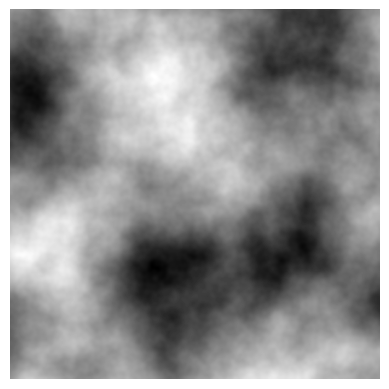

In [17]:
plt.imshow(generate_fractal_noise_2d((512, 512), (2, 2), octaves=6).get(), cmap='gray'); plt.axis('off')

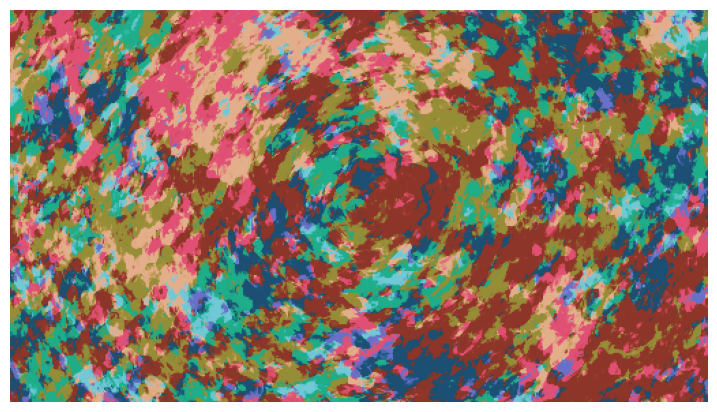

In [23]:
seed = np.random.choice(2**10)
np.random.seed(seed)
projection_config = None
# cppn = CPPN(net_size, dim_in, dim_z, dim_c, projection_config=projection_config).cuda()
sampler = Sampler(cppn)
cppn.reinit(empty_cache=True)

gscale = 1.
scale = 2.
xres = 512
yres = int(512*9/16)
zscale = 3.
nscale = 0

z =  torch.randn(1, dim_z).cuda()
delta_v = torch.randn(1, dim_z).cuda() 
# delta_v = delta_v / torch.norm(delta_v)
z2 = z + 0.02*delta_v
coords = cppn._coordinates(scale*gscale,
                           xres, yres, z*zscale
                           *gscale, num_nulls=4)


def transform_coordinates(coords, hires_res=None):
    # transform the coordinates in some way (and make use of the null coordinates [3, 4, 5]
    # to modify the inputs to the CPPN.
    
    ###
    # a_1, a_2 = 0.75, 0.25
    # w_1, w_2 = 2, 5
    # coords[3] = a_1 * (torch.cos( w_1 * coords[0] ) + torch.cos( w_1 * coords[1] )) / 2
    # coords[4] = a_2 * (torch.cos( w_2 * coords[0] ) + torch.cos( w_2 * coords[1] )) / 2
    # coords[5] = 0.1 * torch.cos( (w_1 + w_2) * coords[2] )
    # 
    # coords[0] = torch.abs(coords[0])
    # coords[1] = torch.abs(coords[1])
    ###
    
    # coords[2] *= 0
    
    if hires_res is not None:
        xr, yr = hires_res
    else: 
        xr, yr = xres, yres
        
    # coords[2] = 1 * make_circle((xr, yr), radius=1).reshape(*coords[3].shape)
    # coords[2] = 8 * torch.cuda.FloatTensor(generate_fractal_noise_2d((yr, xr), (2, 2), octaves=5).get()).reshape(*coords[3].shape)
    # coords[0] = torch.cos(2 * coords[0])
    # coords[1] = torch.sin(2 * coords[1])
    # coords[2] *= 0.
    # coords[2] = 0 * coords[2]
    # coords[2] = coords[0] // 2 + coords[1] // 2
    return coords

coords = transform_coordinates(coords)

# coords[5] = 0.5 * load_image_to_coords(target_file, (xres, yres), coords)
# coords[4] = 30 * (1 - make_circle((xres, yres), radius=1).reshape(*coords[4].shape))
# coords[5] = 1.5 * inject_perlin_noise((yres,xres)).reshape(*coords[5].shape)

cppn.eval()
x = sampler.generate_img(cppn, z*zscale, scale, xres, yres, coords=coords)
sampler.imshow((x * 255).astype(np.uint8))

# Train

In [21]:
# target_file = '../targets/pug.png'
# target_file = '../targets/water.jpg'
# target_file = '../targets/tu2.jpg'
# target_file = '../targets/tu_home.jpg'
# target_file = '../targets/eye1.jpg'
target_file = '../targets/weststadt.jpg'
img = Image.open(target_file) #.rotate(90, expand=True)
img_mean = np.mean(img)
img_std = np.std(img)
# img = (img - np.mean(img)) / np.std(img)
shape = np.array(img).shape
aspectratio = shape[0] / shape[1]
MSELoss = nn.MSELoss()

In [22]:
torch.cuda.empty_cache()
# del TARGET, x, out

Here we make a target image that is actually a combination of a couple different images averages together. Sometimes this comes out strangely psychedelic and nice.

In [23]:
# img_names = ['eye1.jpg', 'lion.jpg', 'wolf.jpg']
# imgs = []
# for im_n in img_names:
#     target_file = f'../targets/{im_n}'
#     imgs.append(
#         np.array(resize_and_crop(target_file, (768, 768)))
#     )
# # target img
# img = np.array(imgs).mean(axis=0)
# img = Image.fromarray(np.uint8(img))
# 
# # normalization stuff
# img_mean = np.mean(img)
# img_std = np.std(img)
# shape = np.array(img).shape
# aspectratio = shape[0] / shape[1]
# MSELoss = nn.MSELoss()

In [24]:
# freeze all but non-fourier feature params
# (not a good trick lol)
'''
for name, params in cppn.named_parameters():
    if ('rule.projection_seq' not in name) and ('rule.in_coords' not in name):
        params.requires_grad=False
    print(f'{name}: {params.requires_grad}')
'''

"\nfor name, params in cppn.named_parameters():\n    if ('rule.projection_seq' not in name) and ('rule.in_coords' not in name):\n        params.requires_grad=False\n    print(f'{name}: {params.requires_grad}')\n"

In [25]:
def sparse_freeze(model, sparsity):
    for m in model.rule.children():
        for l in m.children():
            if np.random.random() < sparsity:
                for p in l.parameters():
                    p.requires_grad = False
            else:
                for p in l.parameters():
                    p.requires_grad = True

def unfreeze_all(model):
    for m in model.rule.children():
        for l in m.children():
            for p in l.parameters():
                p.requires_grad = True

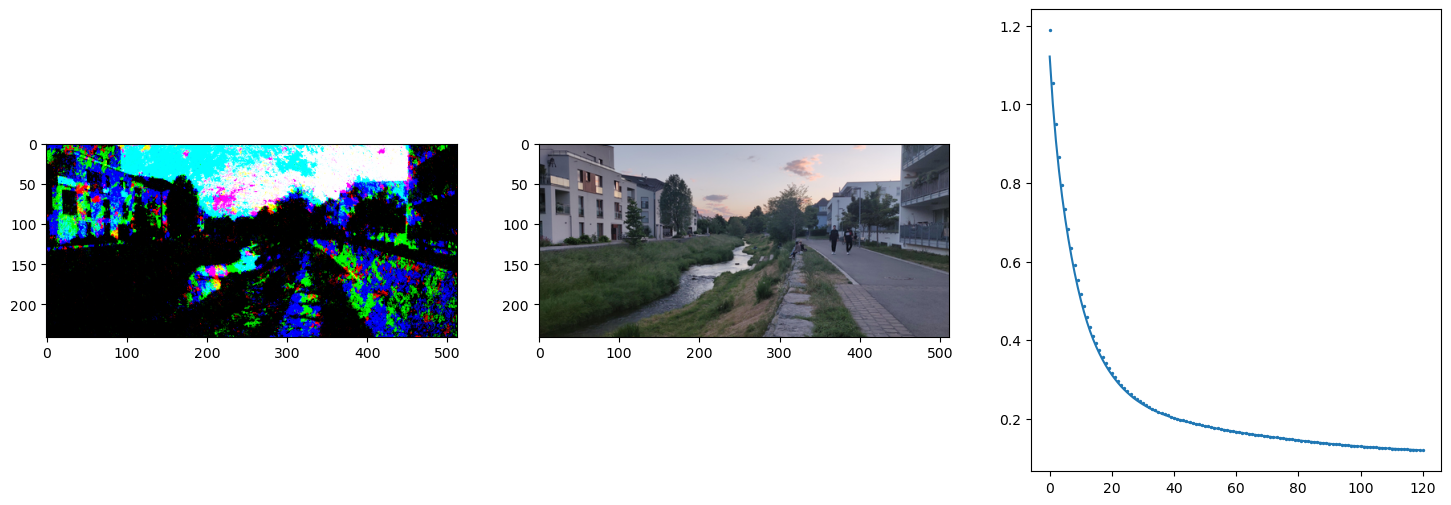

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [35]:
EPOCHS=20000
XRES=512
YRES=int(XRES * aspectratio)
BATCH_SIZE=1
var_z = 0. # variation in latent vector z across batch  
coordinate_noise = 0.0001  # variation in spatial coordinates 

MASK_INDEX = 0

TARGET = np.array(img.resize((XRES, YRES), Image.ANTIALIAS))
mask = torch.cuda.FloatTensor(TARGET[:, :, MASK_INDEX] > -1).reshape(-1)
mask = mask.unsqueeze(0).unsqueeze(-1)

TARGET = TARGET[:, :, :3].reshape(1, -1, 3).astype('float64')
# TARGET = TARGET/TARGET.max()
TARGET = torch.cuda.FloatTensor(np.tile(TARGET, (BATCH_SIZE, 1, 1)))

losses = []


### FREEZE LAYERS
toggle_freeze = False
sparsity = 0.5

# first unfreeze everything
# then freeze if needed
if toggle_freeze:
    unfreeze_all(cppn)
    sparse_freeze(cppn, sparsity)

# all the multiscale stuff doesn't seem to work anymore :(
multiscale_target = False
big_factor = 0.5
change_target_time = 500
keep_full = True
num_full = 1


# what even is this
multiscale = False
scale_range = 1

scale_in = scale
zscale = zscale
# z = torch.randn(BATCH_SIZE, dim_z).cuda()
z_in = zscale * z.repeat(BATCH_SIZE, 1)


optim = torch.optim.Adam(cppn.parameters(), lr=2e-4)
# optim = torch.optim.LBFGS(, lr=1e-3)
lambda1 = lambda epoch: 1 / (1 + epoch // 150)
scheduler = torch.optim.lr_scheduler.LambdaLR(optim, lr_lambda=lambda1)
need_new_grid = True


learn_z = nn.Parameter()

for epoch in range(EPOCHS):
    optim.zero_grad()
    
#     z_in = zscale * torch.randn(BATCH_SIZE, dim_z).cuda()

    
    delta_z = var_z*torch.randn(BATCH_SIZE, dim_z).cuda()
    zt = z_in + delta_z

    if need_new_grid:
        
        x = cppn._coordinates(scale_in, xres=XRES, yres=YRES, z=zt, batch_size=BATCH_SIZE, num_nulls=num_nulls)
        x = transform_coordinates(x)
        # x[3] = x[3] * 0. # remove radial
        if multiscale_target:
            x, TARGET = multiscale_targets_apply(x, img, XRES, YRES, BATCH_SIZE, big_factor, keep_full, num_full)
        
        if multiscale and not multiscale_target: # both multiscaling can't be on at the same time
            scale_factor = 10**( scale_range * (np.random.uniform(size=BATCH_SIZE) - 1/2) )[:,  np.newaxis, np.newaxis]
            x[0] = x[0]*scale_factor
            x[1] = x[1]*scale_factor
            x[2] = x[2]*np.sqrt(scale_factor)
            x[-1] = x[-1]*torch.from_numpy(scale_factor).float().cuda()
            
        need_new_grid = False
    else:
        x = x[:-1]
        x.append(zt.unsqueeze(1))  # remove z layer inputs and replace with new z
        
        if multiscale:
            x[-1] = x[-1]*torch.from_numpy(scale_factor).float().cuda()

    
    # add a bit of nosie to coordinates
    x = [x_i + coordinate_noise * torch.randn_like(x_i) for x_i in x[:-1]] + [x[-1]]
    # out = cppn.forward(x, XRES, YRES)
    out = cppn.forward(x)
    
    
#     out_masked = out * mask
#     TARGET = TARGET * mask
#     loss = -ssim_loss(out.reshape(BATCH_SIZE, YRES, XRES, 3) , TARGET.reshape(-1, YRES, XRES, 3))
    # loss = -ssim_loss(out.mean(2).reshape(BATCH_SIZE, YRES, XRES, 1) , TARGET.mean(2).reshape(-1, YRES, XRES, 1))
    out = (out - out.mean(dim=[0, 1, 2], keepdim=True)) / out.std(dim=[0, 1, 2], keepdim=True)
    # out = (out - img_mean) / img_std
    target = (TARGET - img_mean) / img_std
    # loss = MSELoss(out, target) # color loss
    loss = MSELoss(out.mean(2), target.mean(2)) # b/w loss (often prettier because the colours get to do what the want)
#     loss = MSELoss(out.unsqueeze(1), TARGET.unsqueeze(1))
    loss.backward()
    optim.step()
    scheduler.step()
    
    losses.append(loss.item())
    

    
    if multiscale_target and epoch % change_target_time == 0:
        x = cppn._coordinates(scale_in, xres=XRES, yres=YRES, z=zt, batch_size=BATCH_SIZE, num_nulls=num_nulls)
        x = transform_coordinates(x)
        x, TARGET = multiscale_targets_apply(x, img, XRES, YRES, BATCH_SIZE, big_factor, keep_full, num_full)   
    
    if epoch % 30 == 0:
        alpha = 0.5
        rand_ind = np.random.randint(len(out))
#         rand_ind = 0
#         nx = min_max(out[rand_ind].detach().cpu().numpy().reshape(YRES, XRES, -1) * img_std + img_mean)
        nx = min_max(out[rand_ind].detach().cpu().numpy().reshape(YRES, XRES, -1))
#         nx = out[rand_ind].detach().cpu().numpy().reshape(YRES, XRES, -1)
        s_losses = alpha * np.array(losses[:-1]) + (1 - alpha) * np.array(losses[1:])

        plt.clf()
        fig, ax = plt.subplots(1, 3, figsize=(18, 6))
        ax[0].imshow(nx)
        ax[2].plot(s_losses)
        ax[2].scatter(np.arange(len(losses)), losses, s=2)
        # ax[1].imshow(TARGET[rand_ind].cpu().numpy().reshape(YRES, XRES, 3) / 255.)
        ax[1].imshow(min_max(TARGET[0].cpu().numpy().reshape(YRES, XRES, 3)))

        clear_output(wait=True)
        print(f'{epoch}')
        display(plt.gcf())
        time.sleep(0.001)
        plt.close()
        
    if epoch % 500 == 0 and epoch != 0:
        XRES += 4
        YRES += 4 
        need_new_grid = True
        
        TARGET = np.array(img.resize((XRES, YRES), Image.ANTIALIAS))        
        mask = torch.cuda.FloatTensor(TARGET[:, :, MASK_INDEX] > 1e-5).reshape(-1)
        mask = mask.unsqueeze(0).unsqueeze(-1)
        
        TARGET = TARGET[:, :, :3].reshape(1, -1, 3).astype('float64')

        TARGET = torch.cuda.FloatTensor(TARGET)
        
        
        
    


  ## Hires

In [ ]:
target_file = '../targets/water.jpg'
img = Image.open(target_file)
new_img = resize_and_crop(target_file, (x_dim * x_reps, y_dim * y_reps))
new_img = torch.cuda.FloatTensor(np.array(new_img).mean(axis=-1)).reshape(*coords_hires[0].shape) / 255.
new_img = new_img - new_img.mean()

100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


(2880, 5120, 3)


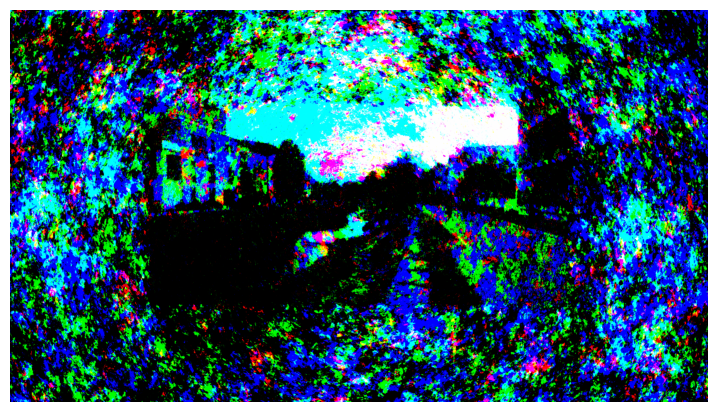

In [37]:
x_reps = 10
y_reps = 10
x_dim = 512
y_dim = int(x_dim * 9/16) #* aspectratio)
# x_dim = 512
# y_dim = int(x_dim * aspectratio)
hi_xres = x_reps*x_dim
hi_yres = y_reps*y_dim

scale_hires = scale*gscale * 2
z_hires = z*zscale*gscale
coords_hires = cppn._coordinates(scale_hires, hi_xres, hi_yres, z_hires, flatten=False, num_nulls=num_nulls)

coords_hires = transform_coordinates(coords_hires, (hi_xres, hi_yres))
# coords_hires[5] = 0.5 * load_image_to_coords(target_file, (x_reps*x_dim, y_reps*y_dim), coords_hires)
# coords_hires[4] = 15 * (1 - make_circle((x_reps*x_dim, y_reps*y_dim), radius=1.35).reshape(*coords_hires[4].shape))

# np.random.seed(seed) # used for perlin noise 
# coords_hires[5] = 1.5 * inject_perlin_noise((y_reps*y_dim,x_reps*x_dim)).reshape(*coords_hires[5].shape)  # (slow as hell)

# crop = int((512*16 - 512*9)/2)
# coords_hires[-2] = nscale*scale*np.array(n_hires)[crop:-crop, :][np.newaxis, :]

# coords[0] = coords[0] + np.cos(coords[0]/2)
# coords[1] = coords[1] + np.sin(coords[1]/2)
# coords[3] = coords[3].cpu().numpy() * (1 + 1/coords[2])
# coords_hires[3] = 1 * new_img

x = sampler.generate_hires(cppn, z=z_hires, scale=scale, x_dim=x_dim, y_dim=y_dim, x_reps=x_reps, y_reps=y_reps, coords=coords_hires)
# x = (x - x.mean()) / x.std()
# x = min_max((x * img_std) + img_mean)
x = min_max(x)
print(x.shape)
sampler.imshow(x)
  
time_str = datetime.now().strftime("%y-%m-%d-%H-%M-%S.%f")
figname = '../output/hi_res/' + time_str + '.png'
imageio.imwrite(figname, (x * 255).astype(np.uint8), format='png')

In [37]:
coords_hires[4] = 50 * make_circle((x_reps*x_dim, y_reps*y_dim), radius=1).reshape(*coords_hires[4].shape)
# coords_hires[5] = coords_hires[5] * 1.5

x = sampler.generate_hires(cppn, z=z_hires, scale=scale, x_dim=x_dim, y_dim=y_dim, x_reps=x_reps, y_reps=y_reps, coords=coords_hires)
# x = (x - x.mean()) / x.std()
# x = min_max((x * img_std) + img_mean)
x = min_max(x)
print(x.shape)
sampler.imshow(x)
  
time_str = datetime.now().strftime("%y-%m-%d-%H-%M-%S.%f")
figname = '../output/hi_res/' + time_str + '.png'
imageio.imwrite(figname, (x * 255).astype(np.uint8), format='png')

 10%|█         | 1/10 [00:00<00:08,  1.03it/s]


KeyboardInterrupt: 